In [2]:
import pandas as pd
import numpy as np
import os
import json
import random
from tqdm import tqdm

In [3]:
from src.f_utils.embedding_utils import load_embeddings

# Dados

## dataset

In [4]:
val_dataset = load_embeddings('artifacts/datasets/balanced_validation_dataset.npy')

✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (2279,)


In [5]:
val_dataset[0]

{'study_index': 0,
 'study_id': 's50414267',
 'patient_id': 'p10000032',
 'files_images': ['02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg',
  '174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.jpg'],
 'embedding_images': [array([-0.02441736,  0.03465954,  0.00766411, ..., -0.01386673,
          0.06212181,  0.01484995], dtype=float32),
  array([-0.03161281,  0.03163843,  0.00890976, ..., -0.01544448,
          0.05352064,  0.01552592], dtype=float32)],
 'file_text': 's50414267.txt',
 'embedding_text': array([-0.01413504,  0.01464215, -0.02659141, ..., -0.03464624,
        -0.07638288, -0.01550421], dtype=float32),
 'study_labels': ['No Finding']}

## labels

In [6]:
df_labels = pd.read_csv("../dados/mimic/mimic-cxr-2.0.0-chexpert.csv")
df_labels.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [7]:
val_study_ids = [study['study_id'] for study in val_dataset]
# extrair 's' de 'study_id'
val_study_ids = [int(study_id[1:]) for study_id in val_study_ids]

# filtrar df_labels por val_study_ids
df_labels_val = df_labels[df_labels['study_id'].isin(val_study_ids)].copy()
df_labels_val.shape

(2279, 16)

## Vector Store

In [8]:
import faiss

# Load the FAISS index
index = faiss.read_index('artifacts/vector_store/faiss_study.index')

# Get the study indices from validation dataset
val_study_indices = [item['study_index'] for item in val_dataset]

# Create a new index with only the validation data
# First, we need to get the vectors corresponding to the validation indices
val_vectors = []
for study_idx in val_study_indices:
    # Reconstruct the vector from the original index
    vector = index.reconstruct(study_idx)
    val_vectors.append(vector)

# Convert to numpy array
val_vectors = np.array(val_vectors)

# Create new FAISS index with filtered data
filtered_index = faiss.IndexFlatIP(val_vectors.shape[1])  # or IndexFlatL2 depending on your original index
filtered_index.add(val_vectors)

# Save the filtered index
# faiss.write_index(filtered_index, 'artifacts/vector_store/faiss_validation_filtered.index')

In [9]:
filtered_index.ntotal

2279

## IDs

In [10]:
ids = load_embeddings('artifacts/embeddings/study_ids.npy')

✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835,)


In [11]:
ids[0]

's50414267'

# Avaliação

O que queremos ver?  
  
1) jaccard indice: interseccao labels / uniao labels do estudo de entrada vs. estudo recuperado
    - proporcao de estudos recuperados em que jaccard = 1 (deu match em todas as labels)
    - média do indice de jaccard
2) recall/f1 sei lá:
    - cria df_gabarito: todos os casos relevantes - em que todos os labels batem ou em que pelo menos 1 bate??
        - df_gabarito é o graund truth (GT) = casos relevantes
        - casos retornados pelo rag = RC (rag cases) = predicted
    - dos casos retornados pelo sistema rag quantos estao em df_gabarito?
        - precision: casos relevantes retornados/casos retornados
            - (RC intersecao com GT) / (all RC)
        - recall: casos relevantes retornados/casos relevantes
             - (RC intersecao com GT) / (all GT)
3) métricas por classe?


Multiclasse:  
Os valores de precisão e recall também podem ser calculados para problemas de classificação com mais de duas classes. Para obter a **precisão** para uma determinada classe, *dividimos o número de verdadeiros positivos pelo viés do classificador em relação a essa classe (número de vezes que o classificador previu a classe)*. Para calcular o **recall** para uma determinada classe, *dividimos o número de verdadeiros positivos pela prevalência dessa classe (número de vezes que a classe ocorre na amostra de dados)*.

eu pensei em definir as metricas como:
- `recall@k`: casos relevantes retornados nos top k/casos relevantes
- `precision@k`: casos relevantes retornados/casos retornados
- `jaccard_1@k`: proporçao dos top k casos em que jaccard=1
- `jaccard@k`: media dos jaccard pros top k - quão similares realmente são os casos retornados
- `NDGC@k`: Normalized Discounted Cumulative Gain (Ganho Cumulativo Descontado Normalizado) - avaliar o quão bem um sistema classifica os itens por relevância para um usuário

In [12]:
from src.f_utils.evaluation import *
from src.f_utils.rag_search import search_relevant_cases
import torch

In [13]:
val_dataset[0]

{'study_index': 0,
 'study_id': 's50414267',
 'patient_id': 'p10000032',
 'files_images': ['02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg',
  '174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.jpg'],
 'embedding_images': [array([-0.02441736,  0.03465954,  0.00766411, ..., -0.01386673,
          0.06212181,  0.01484995], dtype=float32),
  array([-0.03161281,  0.03163843,  0.00890976, ..., -0.01544448,
          0.05352064,  0.01552592], dtype=float32)],
 'file_text': 's50414267.txt',
 'embedding_text': array([-0.01413504,  0.01464215, -0.02659141, ..., -0.03464624,
        -0.07638288, -0.01550421], dtype=float32),
 'study_labels': ['No Finding']}

In [14]:
filtered_index

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x75b3c3bf6a00> >

In [15]:
## AQUI PODEMOS TESTAR VARIOS ALPHAS
def calculate_study_embedding(emb_text, emb_images, alpha=0.5):
    # Convert to tensors if they are numpy arrays
    if isinstance(emb_text, np.ndarray):
        emb_text = torch.from_numpy(emb_text)
    
    # Convert list of numpy arrays to tensors
    if isinstance(emb_images[0], np.ndarray):
        emb_images = [torch.from_numpy(img) for img in emb_images]
    
    # === 3) faz pooling com imagens de entrada
    # Stacking para [N, D]
    emb_images = torch.stack(emb_images)  # [num_imagens, embedding_dim]
    
    # Pooling (média) ao longo das imagens
    emb_pool = emb_images.mean(dim=0)  # [embedding_dim]
    emb_pool = emb_pool / emb_pool.norm(dim=-1, keepdim=True)

    # === 4) fez media dos embeddings para embedding final
    e_study = alpha * emb_text + (1 - alpha) * emb_pool
    e_study = e_study / e_study.norm(dim=-1, keepdim=True)

    return e_study.detach().cpu().numpy()  # Return as numpy for FAISS

## teste caso único

In [16]:
df_labels_val.fillna(0, inplace=True)
binary_cols = [col for col in df_labels_val.columns if col not in ['subject_id', 'study_id']]
for c in binary_cols:
    df_labels_val[c] = np.where(df_labels_val[c] == 1, 1, 0)

In [17]:
# para cada item de val_dataset, calcular os top k
# k=2

study = val_dataset[0]

# Get the study index from the original index
study_index = study['study_index']
print(study_index)

# Get the study vector from the original index
study_vector = calculate_study_embedding(study['embedding_text'], study['embedding_images'], alpha=0.5) # ajustei a função para pular o primeiro caso
print(study_vector)

# Search the filtered index for the top k most similar vectors
k = 5
estudos, idxs = search_relevant_cases(study_vector, filtered_index, ids, k)
print(estudos) # study_ids
print(idxs)    # study_indices

# Get the labels of the top k most similar vectors
study_top_k = []
for i in idxs:
    study_top_k.append({
        'study_id': val_dataset[i]['study_index'],
        'study_id': val_dataset[i]['study_id'],
        'labels': val_dataset[i]['study_labels']
    })
print(study_top_k)

list_set_top_k = [(set(study['labels'])) for study in study_top_k]
print(list_set_top_k)

# Get the ground truth labels for the study
ground_truth_labels = set(study['study_labels'])
print(ground_truth_labels)

# Create a list of sets with all the labels from all the studys with at least one similar label
from src.f_utils.mimic_labels import _get_gabarito_any

gabarito = _get_gabarito_any(int(study['study_id'].replace('s', '')), df_labels_val)

# Criar mapeamento study_id -> labels
gabarito_list_set = []
for _, row in gabarito.iterrows():
    # Pegar labels onde o valor é 1
    labels = [col for col in binary_cols if row[col] == 1.0]
    gabarito_list_set.append(set(labels))

# Classification Report
from sklearn.metrics import classification_report

# True labels repeated
y_true = []
for i in range(k):
    y_true.append(df_labels_val.loc[df_labels_val.study_id == int(study['study_id'].replace('s', ''))][binary_cols].values.tolist()[0])

y_pred = []
for s in study_top_k:
    y_pred.append(df_labels_val.loc[df_labels_val.study_id == int(s['study_id'].replace('s', ''))][binary_cols].values.tolist()[0])

# Evalueate the results
evaluate_single_query(ground_truth_labels, list_set_top_k, gabarito_list_set, k)

0
[-0.0334062   0.03788849 -0.01433749 ... -0.03892397 -0.01412872
 -0.00012285]
['s55962269', 's59238247', 's52590350', 's57069032', 's56799383']
[1789  190 1381  315 1909]
[{'study_id': 's58584362', 'labels': ['No Finding']}, {'study_id': 's50151008', 'labels': ['No Finding']}, {'study_id': 's51128682', 'labels': ['Lung Lesion']}, {'study_id': 's51071301', 'labels': ['Lung Opacity', 'Pneumonia']}, {'study_id': 's50543582', 'labels': ['Lung Opacity']}]
[{'No Finding'}, {'No Finding'}, {'Lung Lesion'}, {'Pneumonia', 'Lung Opacity'}, {'Lung Opacity'}]
{'No Finding'}


{'precision@k': 0.4,
 'recall@k': 0.0026490066225165563,
 'jaccard_1@k': 0.4,
 'jaccard@k': 0.4,
 'ndcg@k': 1.0}

# Testando para vários alpha's 

In [20]:
def evaluate_alpha(dataset, index, alpha, k=5):

    results = [] # lista de sets de labels para cada estudo de consulta
    retrived = [] # lista de listas de sets (resultados por query) retrieved[i][j] = labels do resultado j da query i

    for study in dataset:

        # Get the embedding vector for the study
        study_vector = calculate_study_embedding(study['embedding_text'], study['embedding_images'],alpha=alpha) # ajustei a função para pular o primeiro caso
        
        # Search the filtered index for the top k most similar vectors
        estudos, idxs = search_relevant_cases(study_vector, index, ids, k)

        # Cria o gabarito para mandar pra função
        gabarito = _get_gabarito_any(int(study['study_id'].replace('s', '')), df_labels_val)

        # Criar mapeamento study_id -> labels
        binary_cols = [col for col in df_labels_val.columns if col not in ['subject_id', 'study_id']]
        gabarito_list_set = []
        for _, row in gabarito.iterrows():
            # Pegar labels onde o valor é 1
            labels = [col for col in binary_cols if row[col] == 1.0]
            gabarito_list_set.append(set(labels))

        
        # Get the labels of the top k most similar vectors
        study_top_k = []
        for i in idxs:
            study_top_k.append({
                'study_id': val_dataset[i]['study_index'],
                'study_id': val_dataset[i]['study_id'],
                'labels': val_dataset[i]['study_labels']
            })

        ground_truth_labels = set(study['study_labels'])
        list_set_top_k = [(set(s['labels'])) for s in study_top_k]

        metrics = evaluate_single_query(ground_truth_labels, list_set_top_k, gabarito_list_set, k)

        results.append(metrics)

        
        # True labels repeated
        
        for i in range(k):
            y_true.append(df_labels_val.loc[df_labels_val.study_id == int(study['study_id'].replace('s', ''))][binary_cols].values.tolist()[0])

        for s in study_top_k:
            y_pred.append(df_labels_val.loc[df_labels_val.study_id == int(s['study_id'].replace('s', ''))][binary_cols].values.tolist()[0])


    # Média final das métricas
    mean_metrics = {
        m: np.mean([res[m] for res in results])
        for m in results[0]
    }

    return mean_metrics

In [21]:
image_embeddings = load_embeddings('artifacts/embeddings/e_img.npy')
txt_embeddings = load_embeddings('artifacts/embeddings/e_text.npy')
study_emb = load_embeddings('artifacts/embeddings/e_study.npy')

✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835, 1152)
✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835, 1152)
✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835, 1152)


In [22]:
alphas = np.arange(0, 1.125, 0.125)  # peso dado ao embedding de imagem (vai tetar 5 valores entre 0.3 e 0.7)
results = {}

print("Avaliando diferentes pesos α (imagem)...")

for alpha in tqdm(alphas):
    e_study = alpha * txt_embeddings + (1 - alpha) * image_embeddings
    e_study = torch.from_numpy(e_study)
    e_study = e_study / e_study.norm(dim=-1, keepdim=True)
    e_study = e_study.numpy()

    # Criar FAISS index diretamente
    dimension = e_study.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner Product para similaridade de cosseno

    # Normalizar embeddings para usar inner product como similaridade de cosseno
    faiss.normalize_L2(e_study)

    # Adicionar embeddings ao index
    index.add(e_study)

    val_vectors = []
    for study_idx in val_study_indices:
        # Reconstruct the vector from the original index
        vector = index.reconstruct(study_idx)
        val_vectors.append(vector)

    # Convert to numpy array
    val_vectors = np.array(val_vectors)

    # Create new FAISS index with filtered data
    filtered_index = faiss.IndexFlatIP(val_vectors.shape[1])  # or IndexFlatL2 depending on your original index
    filtered_index.add(val_vectors)

    print('Index Criado.')

    res = evaluate_alpha(val_dataset, filtered_index, alpha, k=5)
    results[alpha] = res

Avaliando diferentes pesos α (imagem)...


  0%|          | 0/9 [00:00<?, ?it/s]

Index Criado.


 11%|█         | 1/9 [03:09<25:13, 189.23s/it]

Index Criado.


 22%|██▏       | 2/9 [06:18<22:06, 189.51s/it]

Index Criado.


 33%|███▎      | 3/9 [09:27<18:54, 189.10s/it]

Index Criado.


 44%|████▍     | 4/9 [12:36<15:44, 188.98s/it]

Index Criado.


 56%|█████▌    | 5/9 [15:45<12:35, 188.93s/it]

Index Criado.


 67%|██████▋   | 6/9 [18:53<09:26, 188.77s/it]

Index Criado.


 78%|███████▊  | 7/9 [22:02<06:17, 188.83s/it]

Index Criado.


 89%|████████▉ | 8/9 [25:11<03:08, 188.74s/it]

Index Criado.


100%|██████████| 9/9 [28:19<00:00, 188.88s/it]


In [23]:
best_alpha = max(results, key=lambda a: results[a]["jaccard_1@k"])
print(f"\nMelhor α (imagem) de acordo com jaccard_1@k: {best_alpha:.2f}")
print("Detalhes:", results[best_alpha])


Melhor α (imagem) de acordo com jaccard_1@k: 0.62
Detalhes: {'precision@k': 0.6581834137779728, 'recall@k': 0.004197385245657483, 'jaccard_1@k': 0.25476086002632736, 'jaccard@k': 0.4141923497496117, 'ndcg@k': 0.7249910345753975}


In [24]:
results

{0.0: {'precision@k': 0.3898200965335674,
  'recall@k': 0.0023550569268286827,
  'jaccard_1@k': 0.13690215006581835,
  'jaccard@k': 0.22303903132117261,
  'ndcg@k': 0.5788308087903704},
 0.125: {'precision@k': 0.5562966213251426,
  'recall@k': 0.0034366318888484023,
  'jaccard_1@k': 0.21737604212373848,
  'jaccard@k': 0.3379994706673074,
  'ndcg@k': 0.6757284778180934},
 0.25: {'precision@k': 0.6220272049144361,
  'recall@k': 0.003925996579688163,
  'jaccard_1@k': 0.24107064501974548,
  'jaccard@k': 0.38516350111786707,
  'ndcg@k': 0.7029555382969952},
 0.375: {'precision@k': 0.6437911364633611,
  'recall@k': 0.004079433225210224,
  'jaccard_1@k': 0.2510750329091707,
  'jaccard@k': 0.40462716869693616,
  'ndcg@k': 0.718952926708286},
 0.5: {'precision@k': 0.651250548486178,
  'recall@k': 0.004135636488839418,
  'jaccard_1@k': 0.25397103992979375,
  'jaccard@k': 0.4108032623609631,
  'ndcg@k': 0.7243814636322372},
 0.625: {'precision@k': 0.6581834137779728,
  'recall@k': 0.0041973852456

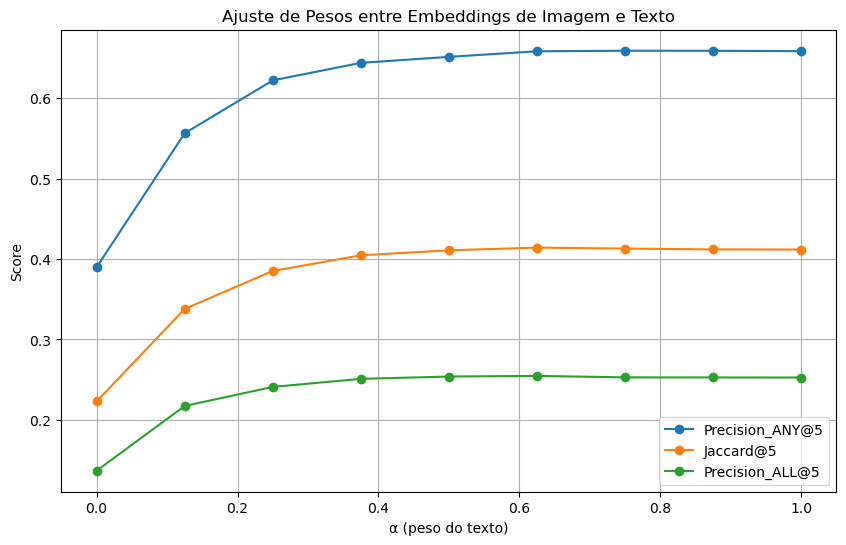

In [27]:
import matplotlib.pyplot as plt

recalls = [results[a]["recall@k"] for a in alphas]
precisions = [results[a]["precision@k"] for a in alphas]
ndcgs = [results[a]["ndcg@k"] for a in alphas]
jaccards = [results[a]["jaccard@k"] for a in alphas]
jaccards_1 = [results[a]["jaccard_1@k"] for a in alphas]

plt.figure(figsize=(10,6))
plt.plot(alphas, precisions, marker="o", label="Precision_ANY@5")
plt.plot(alphas, jaccards, marker="o", label="Jaccard@5")
plt.plot(alphas, jaccards_1, marker="o", label="Precision_ALL@5")
plt.xlabel("α (peso do texto)")
plt.ylabel("Score")
plt.title("Ajuste de Pesos entre Embeddings de Imagem e Texto")
plt.grid(True)
plt.legend()
plt.show()